In [130]:
import time
import timeit
import os
import requests
import base64
from dotenv import load_dotenv
import json
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("data/spotify_data.csv", index_col=0)
df.head(10)

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.043,0.694,0.000,0.115,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.026,0.477,0.000,0.097,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.032,0.338,0.000,0.089,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.036,0.807,0.000,0.080,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.030,0.073,0.019,0.110,0.217,171.864,244320,4
5,Chris Smither,What They Say,24NvptbNKGs6sPy1Vh1O0v,48,2012,acoustic,0.566,0.570,2,-6.420,1,0.033,0.688,0.000,0.094,0.960,83.403,166240,4
6,Matt Wertz,Walking in a Winter Wonderland,0BP7hSvLAG3URGrEvNNbGM,48,2012,acoustic,0.575,0.606,9,-8.197,1,0.030,0.012,0.000,0.068,0.364,121.083,152307,4
7,Green River Ordinance,Dancing Shoes,3Y6BuzQCg9p4yH347Nn8OW,45,2012,acoustic,0.586,0.423,7,-7.459,1,0.026,0.252,0.000,0.098,0.318,138.133,232373,4
8,Jason Mraz,Living in the Moment,3ce7k1L4EkZppZPz1EJWTS,44,2012,acoustic,0.650,0.628,7,-7.160,1,0.023,0.048,0.000,0.119,0.700,84.141,235080,4
9,Boyce Avenue,Heaven,2EKxmYmUdAVXlaHCnnW13o,58,2012,acoustic,0.619,0.280,8,-10.238,0,0.032,0.730,0.000,0.103,0.292,129.948,250063,4


## Exploratory Data Analysis

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159764 entries, 0 to 1473395
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   artist_name       1159749 non-null  object 
 1   track_name        1159763 non-null  object 
 2   track_id          1159764 non-null  object 
 3   popularity        1159764 non-null  int64  
 4   year              1159764 non-null  int64  
 5   genre             1159764 non-null  object 
 6   danceability      1159764 non-null  float64
 7   energy            1159764 non-null  float64
 8   key               1159764 non-null  int64  
 9   loudness          1159764 non-null  float64
 10  mode              1159764 non-null  int64  
 11  speechiness       1159764 non-null  float64
 12  acousticness      1159764 non-null  float64
 13  instrumentalness  1159764 non-null  float64
 14  liveness          1159764 non-null  float64
 15  valence           1159764 non-null  float64
 16  tempo

In [5]:
df.describe()

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000
mean,18.383,2011.955,0.537,0.640,5.288,-8.981,0.635,0.093,0.322,0.252,0.223,0.456,121.377,249561.781,3.886
std,15.886,6.804,0.184,0.271,3.555,5.682,0.482,0.127,0.355,0.365,0.201,0.269,29.780,149426.165,0.468
min,0.000,2000.000,0.000,0.000,0.000,-58.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2073.000,0.000
25%,5.000,2006.000,0.413,0.454,2.000,-10.829,0.000,0.037,0.006,0.000,0.098,0.226,98.797,181091.000,4.000
50%,15.000,2012.000,0.550,0.694,5.000,-7.450,1.000,0.051,0.147,0.002,0.134,0.438,121.931,225744.000,4.000
75%,29.000,2018.000,0.677,0.873,8.000,-5.276,1.000,0.089,0.640,0.614,0.292,0.674,139.903,286913.500,4.000
max,100.000,2023.000,0.993,1.000,11.000,6.172,1.000,0.971,0.996,1.000,1.000,1.000,249.993,6000495.000,5.000


In [6]:
df.isna().any()

artist_name          True
track_name           True
track_id            False
popularity          False
year                False
genre               False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_ms         False
time_signature      False
dtype: bool

In [7]:
sum(df['artist_name'].isna())

15

In [8]:
sum(df['track_name'].isna())

1

(array([4.25164e+05, 2.57757e+05, 1.99251e+05, 1.44216e+05, 8.03860e+04,
        3.70400e+04, 1.25040e+04, 2.94700e+03, 4.71000e+02, 2.80000e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

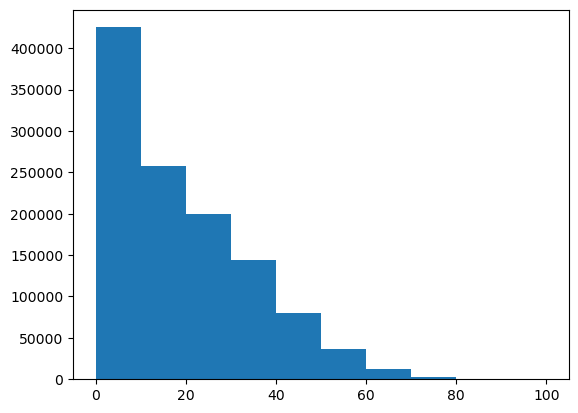

In [88]:
# track popularity (0 to 100)
plt.hist(df['popularity'])

(array([128487.,  85758.,  89254., 140302.,  93312., 108013., 145059.,
        112813., 110859., 145907.]),
 array([2000. , 2002.3, 2004.6, 2006.9, 2009.2, 2011.5, 2013.8, 2016.1,
        2018.4, 2020.7, 2023. ]),
 <BarContainer object of 10 artists>)

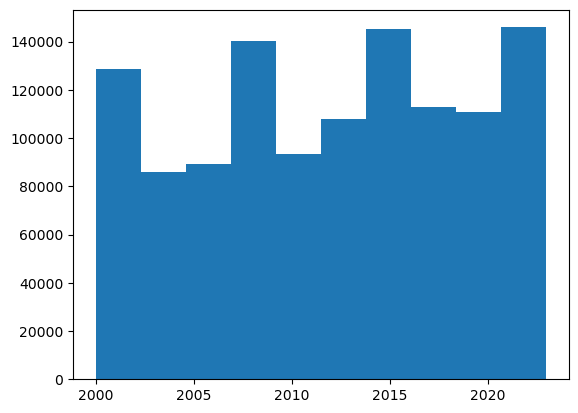

In [91]:
plt.hist(df['year'])

In [95]:
df['genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'ambient', 'black-metal',
       'blues', 'breakbeat', 'cantopop', 'chicago-house', 'chill',
       'classical', 'club', 'comedy', 'country', 'dance', 'dancehall',
       'death-metal', 'deep-house', 'detroit-techno', 'disco',
       'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic',
       'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german',
       'gospel', 'goth', 'grindcore', 'groove', 'guitar', 'hard-rock',
       'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'house',
       'indian', 'indie-pop', 'industrial', 'jazz', 'k-pop', 'metal',
       'metalcore', 'minimal-techno', 'new-age', 'opera', 'party',
       'piano', 'pop', 'pop-film', 'power-pop', 'progressive-house',
       'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll',
       'romance', 'sad', 'salsa', 'samba', 'sertanejo', 'show-tunes',
       'singer-songwriter', 'ska', 'sleep', 'songwriter', 'soul',
       'spanish', 'swedish', 'tango', 'tec

In [96]:
df['genre'].value_counts()

genre
black-metal       21852
gospel            21621
ambient           21389
acoustic          21097
alt-rock          20918
                  ...  
chicago-house      5170
dubstep            4774
detroit-techno     3920
rock               3319
songwriter          589
Name: count, Length: 82, dtype: int64

## Cosine Similarity

In [9]:
df['genre'].value_counts()

genre
black-metal       21852
gospel            21621
ambient           21389
acoustic          21097
alt-rock          20918
                  ...  
chicago-house      5170
dubstep            4774
detroit-techno     3920
rock               3319
songwriter          589
Name: count, Length: 82, dtype: int64

In [10]:
#Selecting only the features that range from 0.0 to 1.0
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df[df['track_id'] == trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b][columns]
    vector_a = np.squeeze(np.array(track_a), axis=0)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)
    
a = df['track_id'].sample().iloc[0]
b = df['track_id'].sample().iloc[0]
visual = df[(df['track_id'] == a) | (df['track_id'] == b)]
print(cosine_similarity(a, b))
visual


0.8942638209671937


,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
385408,XXXTENTACION,CHASE / glass shards,62VGbS3xXFRGDBD8F2ZgPl,44,2019,emo,0.544,0.352,1,-8.603,1,0.319,0.015,0.009,0.132,0.248,85.686,138590,5
861890,Allman Brothers Band,Old Before My Time,2sb9IkeoFSoJwFM5347Xi2,20,2003,blues,0.445,0.578,7,-7.423,1,0.032,0.293,0.001,0.091,0.259,124.902,323840,4


## Import personal playlist data

In [11]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [12]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = 'credentials.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  # Use the path for dotenv
    
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') #verify var names.
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

In [13]:
def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists_json):
    df_playlists = pd.json_normalize(user_playlists_json['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df_playlists, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df_playlists.columns]
    return df_playlists[cleaned_columns]

In [14]:
def getPlaylist(playlist_id, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    all_tracks = []
    response = requests.get(f"{BASE_URL}playlists/{playlist_id}/tracks?limit=100", headers=headers)
    if response.ok:
        data = response.json()
        all_tracks.extend(data['items'])  
        
        while data['next']:
            response = requests.get(data['next'], headers=headers) #Use the 'next' URL provided by the API? Or manual?
            if response.ok:
                data = response.json()
                all_tracks.extend(data['items'])  
            else:
                print(f"Invalid: {response.status_code}, {response.text}")
                break  

        return all_tracks
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

def dfPlaylist(tracks_json):
    tracks = []
    for item in tracks_json:
        track = item.get('track', {})
        if track:  
            track_info = {
                'id': track.get('id'),
                'title': track.get('name'),
                'popularity': track.get('popularity'),
                'album': track['album'].get('name'),
                'release_date': track['album'].get('release_date'),
                'album_total_tracks': track['album'].get('total_tracks'),
                'artist': ', '.join([artist['name'] for artist in track['artists']]), 
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,  
                'album_id': track['album'].get('id')
            }
            tracks.append(track_info)
    
    df_tracks = pd.DataFrame(tracks)
    return df_tracks

In [15]:
def getAudiosFeatures(track_ids, access_token):
    MAX_TRACKS = 100
    all_features = []  
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    for i in range(0, len(track_ids), MAX_TRACKS):
        chunk = track_ids[i:i+MAX_TRACKS]
        track_ids_str = ",".join(chunk)

        response = requests.get(f"{BASE_URL}audio-features?ids={track_ids_str}", headers=headers)
        if response.ok:
            data = response.json()
            all_features.extend(data['audio_features'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
            return None  

    return all_features

def genretoPlaylist(df_tracks, df_artists): #Determine how to flow this.
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

def audioFeaturesDf(audio_features_json): 
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }

            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

In [16]:
access_token = getAuth()
user_playlists = getPlaylists(access_token)
tmp_df = dfPlaylists(user_playlists)
playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])

playlists_original_df.head(20)

,id,name,tracks_total
0,0WBJMqR0deY9xqNgsHKfVX,My Top Songs 2023,100
1,4N5AXGqbUxEW9u40a7WHxu,Relaxing,1
2,33AeYtH6LluJ3hqMRuzeWw,For Driving,43


In [43]:
playlist = getPlaylist(playlists_original_df.iloc[0]['id'], access_token)
df_tracks = dfPlaylist(playlist)

df_tracks.head(20) 

,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id
0,6MCjmGYlw6mQVWRFVgBRvB,夜に駆ける,73,THE BOOK,2021-01-06,9,YOASOBI,64tJ2EAv1R6UaZqc4iOCyj,1xhO0GSoezdPJcSuNe1ySv
1,1YqVJ2YSgwxWpfuENocF2t,"Hello,world!",58,Butterflies,2016-02-10,11,BUMP OF CHICKEN,0hSFeqPehe7FtCNWuQ6Bsy,7xEb9qTZuR3LMPETeHR1A5
2,2vjY3jGKElvqXoaGNEuYef,怪物,68,THE BOOK 2,2021-12-01,8,YOASOBI,64tJ2EAv1R6UaZqc4iOCyj,5uStDUB4nlmItpz2AYlFtd
3,61DmKCuwyiSZMOo7k8C8pT,Radiant,46,Radiant,2021-11-01,1,"塞壬唱片-MSR, Erik Castro, Mary Clare",7l5zSPffvPDaRRYkAHsyt7,3ztW1pVjZEtRFJusUmsN9j
4,0MJ5wsGpqu0gTJkx53ewxc,osmanthus,55,Nerenaiyoruni ka-tenwoakete,2020-10-15,20,"whaledontsleep, Ado",5lEzAveEBteB85UVvKTanp,4ZCMR8iFTEAZNOmJdKB9pn
5,2j6dnY8eehdcnGBiCgRENJ,Sunday Morning Coffee,18,Yunomic Ni Ocha Shite EP,2016-10-12,6,"Yunomi, nicamoq",2j00CVYTPx6q9ANbmB2keb,5g3UxoBQUKnj4b6KR81Duo
6,5UWJxql2C2VNLAusOQRjt1,specialist,56,ネバー・モア-『ペルソナ4』輪廻転生-,2011-10-26,12,アトラスサウンドチーム,4hFBhdNVZZuVk5FYThUwaN,6sYyz749kpPYzQU5gtnuQd
7,3ILWwi1JNj3NGuuf6DzYxN,Flamingo,62,STRAY SHEEP,2020-08-05,15,Kenshi Yonezu,1snhtMLeb2DYoMOcVbb8iB,052EiTRYh35MuDVJN9Emdh
8,6zteUD44VFqJ2Q2qSj411v,愚人曲,39,愚人號 (Original Soundtrack),2022-05-09,6,Steven Grove,7rWS1LAKC05YGpmgSmowvp,5If0Y2dnYxBmXGHVIAW60F
9,2MpxDgIUMeTyekIgVFBjbt,Sakura Saku,21,Yunomic Ni Ocha Shite EP,2016-10-12,6,"Yunomi, nicamoq",2j00CVYTPx6q9ANbmB2keb,5g3UxoBQUKnj4b6KR81Duo


In [18]:
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
df_audio_features = audioFeaturesDf(audio_features)

df_audio_features.head(20)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
6MCjmGYlw6mQVWRFVgBRvB,0.663,0.871,8,-5.287,1,0.030,0.003,0.000,0.337,0.826,130.025,258840,4
1YqVJ2YSgwxWpfuENocF2t,0.597,0.913,8,-5.448,1,0.032,0.004,0.000,0.405,0.713,105.541,248453,4
2vjY3jGKElvqXoaGNEuYef,0.598,0.847,1,-2.540,1,0.205,0.066,0.000,0.307,0.728,169.959,205480,4
61DmKCuwyiSZMOo7k8C8pT,0.491,0.887,3,-4.654,0,0.085,0.000,0.009,0.294,0.233,176.085,252273,4
0MJ5wsGpqu0gTJkx53ewxc,0.685,0.739,7,-4.298,0,0.089,0.020,0.000,0.088,0.791,123.034,140488,4
2j6dnY8eehdcnGBiCgRENJ,0.585,0.792,9,-5.161,1,0.062,0.008,0.000,0.200,0.666,174.012,211724,4
5UWJxql2C2VNLAusOQRjt1,0.564,0.973,8,-7.646,0,0.048,0.015,0.923,0.327,0.779,128.019,243747,4
3ILWwi1JNj3NGuuf6DzYxN,0.760,0.668,7,-6.000,1,0.055,0.165,0.000,0.092,0.913,114.075,196387,4
6zteUD44VFqJ2Q2qSj411v,0.440,0.840,1,-9.578,1,0.053,0.000,0.769,0.384,0.115,139.975,201551,4


## Generate song recommendations based on similarity

1. iterate through each row while using the same cosine_similarity function as before - approximately 11 hours
2. use "apply" instead, keep other things unchanged - still 11 hours (the search in the original cosine_similarity function is taking too much time)
3. current result - about four minutes

```python
# 1 Initial Implementation
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b][columns]
    vector_a = np.array(track_a)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

target_song = '6MCjmGYlw6mQVWRFVgBRvB'
scores = {}

for row in tqdm(df.index):
    scores[row] = cosine_similarity(target_song, df.iloc[row]['track_id'])
```

```python
# 2
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b['track_id']][columns]
    vector_a = np.array(track_a)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

tqdm.pandas()
target_song = '6MCjmGYlw6mQVWRFVgBRvB'

scores = df.progress_apply(lambda x: cosine_similarity(target_song, x), axis=1)
scores
```

In [46]:
# 3
def cosine_similarity_opt3(trackid_a, track_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = track_b[columns]
    vector_a = np.array(track_a)
    vector_b = np.array(track_b)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

tqdm.pandas()
target_song = df_tracks.iloc[0] #Change this to compute scores for other songs

print(f'Computing similarity scores for track: {target_song["title"]} from artist {target_song["artist"]}')
scores = df.progress_apply(lambda x: cosine_similarity_opt3(target_song['id'], x), axis=1)
scores

Computing similarity scores for track: 夜に駆ける from artist YOASOBI


100%|██████████| 1159764/1159764 [04:03<00:00, 4763.56it/s]


0         0.572
1         0.859
2         0.733
3         0.617
4         0.901
           ... 
1473391   0.934
1473392   0.707
1473393   0.666
1473394   0.782
1473395   0.967
Length: 1159764, dtype: float64

## Optimization approaches

1. Enable multiprocessing (since this is a CPU-heavy task) starting with 4 cores:

In [48]:
from functools import partial
from multiprocessing.pool import Pool
from utils import cos_similarity_mp #custom function

def compute_similarity_mp_4cores(df, trackid_a, N_process):
    ts = time.time()
   
    # Split df into segments
    segments = np.array_split(df, N_process)
    
    cos_similarity_segment = partial(cos_similarity_mp, df_audio_features, trackid_a)
    
    with Pool(N_process) as p:
        results = p.map(cos_similarity_segment, segments)
        
    print('Finished in {}s'.format(time.time() - ts))  # Print time taken
    return results

print(f'Computing similarity scores for track with 4-core multiprocessing: {target_song["title"]} from artist {target_song["artist"]}')
compute_similarity_mp_4cores(df, target_song['id'], 4)

Computing similarity scores for track: 夜に駆ける from artist YOASOBI
Finished in 61.9343957901001s


[0        0.572
 1        0.859
 2        0.733
 3        0.617
 4        0.901
           ... 
 289936   0.765
 289937   0.946
 289938   0.856
 289939   0.874
 289940   0.881
 Length: 289941, dtype: float64,
 289941   0.913
 289942   0.872
 289943   0.918
 289944   0.826
 289945   0.897
           ... 
 579877   0.579
 579878   0.186
 579879   0.590
 579880   0.563
 579881   0.129
 Length: 289941, dtype: float64,
 579882    0.090
 579883    0.630
 579884    0.094
 579885    0.105
 579886    0.597
            ... 
 1031685   0.798
 1031686   0.803
 1031687   0.937
 1031688   0.938
 1031689   0.845
 Length: 289941, dtype: float64,
 1031690   0.956
 1031691   0.960
 1031692   0.985
 1031693   0.973
 1031694   0.738
            ... 
 1473391   0.934
 1473392   0.707
 1473393   0.666
 1473394   0.782
 1473395   0.967
 Length: 289941, dtype: float64]

2. Next, let's try multiprocessing with all the cores on the machine. The machine that we are working with has a M1-pro CPU, which has 10 CPU cores.

In [54]:
from multiprocessing import cpu_count

def compute_similarity_mp_max(df, trackid_a):
    ts = time.time()
    N_process = cpu_count()
   
    # Split df into segments
    segments = np.array_split(df, N_process)
    
    cos_similarity_segment = partial(cos_similarity_mp, df_audio_features, trackid_a)
    
    with Pool(N_process) as p:
        results = p.map(cos_similarity_segment, segments)
        
    print('Finished in {}s'.format(time.time() - ts))  # Print time taken
    return results

print(f'Computing similarity scores for track with {cpu_count()}-core multiprocessing: {target_song["title"]} from artist {target_song["artist"]}')
compute_similarity_mp_max(df, target_song['id'])

Computing similarity scores for track with 10-core multiprocessing: 夜に駆ける from artist YOASOBI
Finished in 30.99051308631897s


[0        0.572
 1        0.859
 2        0.733
 3        0.617
 4        0.901
           ... 
 115972   0.380
 115973   0.782
 115974   0.403
 115975   0.752
 115976   0.933
 Length: 115977, dtype: float64,
 115977   0.835
 115978   0.502
 115979   0.780
 115980   0.565
 115981   0.817
           ... 
 231949   0.940
 231950   0.809
 231951   0.963
 231952   0.879
 231953   0.933
 Length: 115977, dtype: float64,
 231954   0.950
 231955   0.964
 231956   0.848
 231957   0.995
 231958   0.882
           ... 
 347926   0.165
 347927   0.190
 347928   0.254
 347929   0.240
 347930   0.189
 Length: 115977, dtype: float64,
 347931   0.254
 347932   0.235
 347933   0.346
 347934   0.198
 347935   0.185
           ... 
 463903   0.859
 463904   0.713
 463905   0.744
 463906   0.775
 463907   0.973
 Length: 115977, dtype: float64,
 463908   0.849
 463909   0.983
 463910   0.979
 463911   0.985
 463912   0.646
           ... 
 579879   0.590
 579880   0.563
 579881   0.129
 579882   0.090
 579

3. Apart from increasing computation power by brute force, we can possibly leverage the power of matrix multiplication to achieve incredible speed boost based on the nature of this task.

In [86]:
ts = time.time()
print(f'Computing similarity scores for track with matrix multiplication: {target_song["title"]} from artist {target_song["artist"]}')

columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
target_vector = df_audio_features.loc[target_song['id']][columns].values
df_vector = df[columns].values
norm_by_row =  (np.linalg.norm(target_vector) * np.linalg.norm(df_vector, axis=1))
results = np.dot(target_vector, df_vector.T) / (np.linalg.norm(target_vector) * np.linalg.norm(df_vector, axis=1))

print('Finished in {}s'.format(time.time() - ts))  # Print time taken
print(results)

Computing similarity scores for track with matrix multiplication: 夜に駆ける from artist YOASOBI
Finished in 0.058973073959350586s
[0.57185137 0.8589564  0.73335956 ... 0.66570556 0.78216148 0.96669819]


For correctness, we can convert the matrix into a Pandas series and inspect it:

In [142]:
pd.Series(results)

0         0.572
1         0.859
2         0.733
3         0.617
4         0.901
           ... 
1159759   0.934
1159760   0.707
1159761   0.666
1159762   0.782
1159763   0.967
Length: 1159764, dtype: float64

As we can see here, the matrix does have 1159764}$ items and the scores match with the scores we got using other methods. Now we can calculate the similarity scores of one song with the entire dataset in an instant!

## Generate artist recommendations

In [139]:
artist = df.groupby(['artist_name']).count()
artist = artist[artist['track_id'] >= 5]
artist_list = list(artist.index.values)

df_copy = df.copy()
df_copy = df_copy[df_copy['artist_name'].isin(artist_list)]
df_copy = df_copy[['artist_name','danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
df_copy

,artist_name,danceability,energy,acousticness,instrumentalness,liveness,valence
0,Jason Mraz,0.483,0.303,0.694,0.000,0.115,0.139
1,Jason Mraz,0.572,0.454,0.477,0.000,0.097,0.515
2,Joshua Hyslop,0.409,0.234,0.338,0.000,0.089,0.145
3,Boyce Avenue,0.392,0.251,0.807,0.000,0.080,0.508
4,Andrew Belle,0.430,0.791,0.073,0.019,0.110,0.217
...,...,...,...,...,...,...,...
1473391,Nicola Conte,0.373,0.742,0.325,0.000,0.159,0.522
1473392,Nicola Conte,0.516,0.675,0.788,0.000,0.130,0.264
1473393,Amon Tobin,0.491,0.440,0.477,0.003,0.094,0.035
1473394,Peace Orchestra,0.480,0.405,0.431,0.000,0.125,0.202


In [124]:
df_copy = df_copy.groupby(['artist_name']).median()
df_copy.head()
df_copy['artist_name'] = df_copy.index

In [125]:
def cosine_similarity_artist(df, artist_name_a, artist_name_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    artist_a = df[df['artist_name'] == artist_name_a][columns]
    artist_b = df[df['artist_name'] == artist_name_b][columns]
    vector_a = np.squeeze(np.array(artist_a), axis=0)
    vector_b = np.squeeze(np.array(artist_b), axis=0)

    dot_product = np.dot(vector_a, vector_b)

    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    return dot_product / (magnitude_a * magnitude_b)

a = df_copy['artist_name'].sample().iloc[0]
b = df_copy['artist_name'].sample().iloc[0]
visual = df_copy[(df_copy['artist_name'] == a) | (df_copy['artist_name'] == b)]
print(cosine_similarity_artist(df_copy, a, b))
visual

0.9660552039862002


,danceability,energy,acousticness,instrumentalness,liveness,valence,artist_name
artist_name,,,,,,,
Deftones,0.332,0.859,0.000,0.307,0.135,0.239,Deftones
The Dreamside,0.475,0.682,0.005,0.155,0.114,0.241,The Dreamside


In [128]:
def cosine_similarity_artist_list(df, artist_name_input):
    df_duplicate = df.copy(deep=True)
    df_duplicate = df_duplicate[:10000] ## running too slow so only took a portion
    if len(df_duplicate.loc[df_duplicate['artist_name'] == artist_name_input]) == 0:
        df_duplicate = pd.concat([df_duplicate, df_copy[df_copy['artist_name'] == artist_name_input]])
        similarity = []

    for value in df_duplicate['artist_name']:
        similarity_value = cosine_similarity_artist(df_duplicate, artist_name_input, value)
        similarity.append(similarity_value)

    df_duplicate['similarity'] = similarity
    df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

    return df_duplicate

In [131]:
start = timeit.default_timer()

TSwift_recommendation = cosine_similarity_artist_list(df_copy,  'Taylor Swift')

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  10.452688833000138


In [132]:
TSwift_recommendation.sort_values(by='similarity', ascending=False)

,danceability,energy,acousticness,instrumentalness,liveness,valence,artist_name,similarity
artist_name,,,,,,,,
Booba,0.727,0.732,0.118,0.000,0.140,0.462,Booba,1.000
Childish Gambino,0.590,0.607,0.090,0.000,0.122,0.399,Childish Gambino,1.000
All About Eve,0.506,0.547,0.106,0.000,0.093,0.365,All About Eve,1.000
Echosmith,0.616,0.672,0.123,0.000,0.113,0.452,Echosmith,0.999
Big K.R.I.T.,0.726,0.692,0.139,0.000,0.138,0.485,Big K.R.I.T.,0.999
...,...,...,...,...,...,...,...,...
Deep Sleep,0.101,0.018,0.865,0.911,0.095,0.047,Deep Sleep,0.167
Crib,0.101,0.007,0.861,0.879,0.109,0.033,Crib,0.161
Baby Sweet Dream,0.032,0.033,0.894,0.950,0.736,0.000,Baby Sweet Dream,0.161


In [135]:
def cosine_similarity_artist_list(df, artist_name_input):
    df_duplicate = df.copy(deep=True)
    similarity = []

    for value in df_duplicate['artist_name']:
        similarity_value = cosine_similarity_artist(df_duplicate, artist_name_input, value)
        similarity.append(similarity_value)

    df_duplicate['similarity'] = similarity
    df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

    return df_duplicate

In [136]:
start = timeit.default_timer()

TSwift_recommendation = cosine_similarity_artist_list(df_copy,  'Taylor Swift')

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  96.58061237500078


In [137]:
TSwift_recommendation.sort_values(by='similarity', ascending=False)

,danceability,energy,acousticness,instrumentalness,liveness,valence,artist_name,similarity
artist_name,,,,,,,,
Sarah Téibo,0.638,0.647,0.115,0.000,0.129,0.417,Sarah Téibo,1.000
Glee Club Singers,0.596,0.597,0.127,0.000,0.121,0.402,Glee Club Singers,1.000
THEY.,0.661,0.689,0.114,0.000,0.142,0.428,THEY.,1.000
No Justice,0.625,0.617,0.126,0.000,0.109,0.403,No Justice,1.000
Redneck Souljers,0.665,0.675,0.144,0.000,0.128,0.465,Redneck Souljers,1.000
...,...,...,...,...,...,...,...,...
Sleep Solution for Tinnitus,0.070,0.037,0.200,0.956,0.140,0.015,Sleep Solution for Tinnitus,0.116
White Noise Sleep Sounds,0.000,0.007,0.908,0.930,0.107,0.000,White Noise Sleep Sounds,0.099
Baby Sleep White Noise,0.000,0.000,0.204,0.950,0.707,0.000,Baby Sleep White Noise,0.093


In [140]:
def cosine_similarity_artist(df, artist_name_a, artist_name_b):
    ## columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence'] # redundant
    artist_a = df[['artist_name'] == artist_name_a]
    artist_b = df[['artist_name'] == artist_name_b]
    vector_a = np.squeeze(np.array(artist_a), axis=0)
    vector_b = np.squeeze(np.array(artist_b), axis=0)

    dot_product = np.dot(vector_a, vector_b)

    return dot_product / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b)) ## remove extra placeholders

def cosine_similarity_artist_list(df, artist_name_input):
    df_duplicate = df.copy(deep=True)
    similarity = []

    for value in df_duplicate['artist_name']:
        similarity_value = cosine_similarity_artist(df_duplicate, artist_name_input, value)
        similarity.append(similarity_value)

    df_duplicate['similarity'] = similarity
    df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

    return df_duplicate
